In [1]:
import sys
import numpy
import pandas
import math

from keras import backend as be
from keras.models import Model,Sequential
from keras.layers import Input, Dense, Embedding, merge, Dropout, LSTM,TimeDistributed
from keras.layers.core import Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler, Callback, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras import metrics, regularizers

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from scipy.stats import rankdata

from time import time
import timeit
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf


Using TensorFlow backend.


(456, 12)


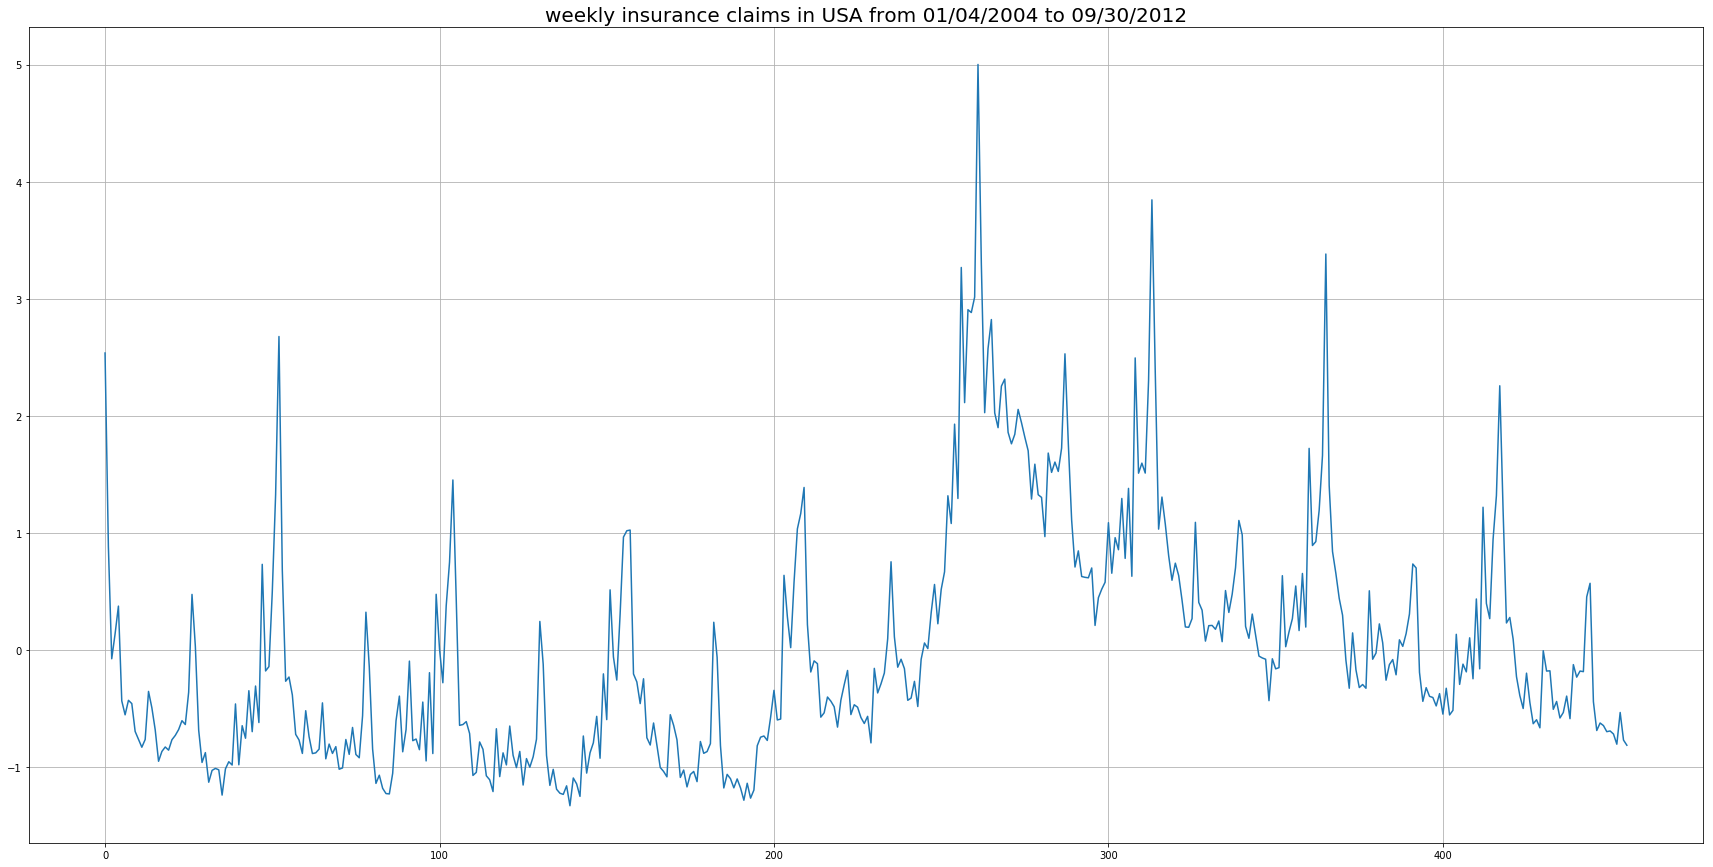

In [2]:
# Basic Data Exploration
iclaim_data = pandas.read_csv('data/steve_scott/claims.csv')
print iclaim_data.shape
plt.figure(figsize=(30,15))
plt.plot(iclaim_data['iclaimsNSA'])
plt.title('weekly insurance claims in USA from 01/04/2004 to 09/30/2012',fontsize=20)
plt.grid(True)

# DATA PROCESSING

In [3]:
class LSTMData(object):
    # DATA
    _FILENAME=''
    RESPONSE_Y = 'iclaimsNSA'
    
    def __init__(self, 
                 filename = 'data/steve_scott/claims.csv',
                 lookback_len = 5 
                ):
        self._FILENAME = filename
        self.iclaim_data = pandas.read_csv(self._FILENAME)
        self.iclaim_data = self.iclaim_data.drop(['date'], 1)

        # training and testing split 90-10
        train_size = int(self.iclaim_data.shape[0] * 0.9)
        test_size = self.iclaim_data.shape[0] - train_size
        
        self.train_data = self.iclaim_data.head(train_size)
        self.test_data = self.iclaim_data.tail(test_size)
        self.LOOKBACK_LEN = lookback_len
        self.EMBEDDING_LEN = self.train_data.shape[1]-1

    def load_data(self):
        corpus_design_matrix = []
        corpus_response = []
        
        # get the features and response
        a_design_matrix = self.train_data.drop(self.RESPONSE_Y, axis=1)
        a_response = self.train_data.loc[:, self.RESPONSE_Y]

        # sliding window to get design matrix
        for i in range(0, self.train_data.shape[0]-self.LOOKBACK_LEN):
            a_sentence = []
            a_sentence_response = []

            # get row from i to (i+SENTENCE_LEN)
            a_window_x = a_design_matrix.iloc[i:(i+self.LOOKBACK_LEN)]
            a_window_y = a_response.iloc[i:(i+self.LOOKBACK_LEN)]

            for index, row in a_window_x.iterrows():
                a_word = row.tolist()
                a_sentence.append(a_word)
            for index, element in a_window_y.iteritems():
                a_word_response = [element]
                a_sentence_response.append(a_word_response)

            # add into final training sets
            corpus_design_matrix.append(a_sentence)
            corpus_response.append(a_sentence_response)

        x = numpy.array(corpus_design_matrix)
        y = numpy.array(corpus_response)

        return x, y

# MODEL

In [4]:
##### 
class LSTM_Model(object):
    # model
    OPTIMIZER_LR_DEFAULT = {'Adam': 0.001, 
                            'Adamax': 0.002,
                            'SGD': 0.01
                            }

    def __init__(self,
                 x_train,
                 y_train,
                 x_test,
                 y_test,
                 epochs,
                 lstm_neurons,
                 dropout,
                 dense_neurons,
                 regularization_para,
                 timesteps,
                 data_dim,
                 batch_size,
                 lr_decay=0.95,
                 lr_decay_steps=60,
                 stateful=False
                ):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.epochs = epochs
        self.lstm_neurons = lstm_neurons
        self.dropout = dropout
        self.dense_neurons = dense_neurons
        self.regularization_para = regularization_para
        self.timesteps = timesteps
        self.data_dim = data_dim
        self.batch_size = batch_size
        self.lr_decay = lr_decay
        self.lr_decay_steps = int(lr_decay_steps)
        self.stateful = stateful
        self.model = Sequential()

    def step_decay(self, epoch):
        optmer = 'Adam'
        initial_lr = 0.01
        
        try:
            initial_lr = self.OPTIMIZER_LR_DEFAULT[optmer]
        except:
            pass

        drop = self.lr_decay
        epochs_drop = int(self.lr_decay_steps) 
        lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
        return lr

    def build(self):
        lstm_out_dim = self.lstm_neurons
        dense_neurons = self.dense_neurons
        timesteps = self.timesteps  
        data_dim = self.data_dim  
        batch_size = self.batch_size   
        stateful = self.stateful
        lstm_activation = 'tanh'  
        dense_activation = 'tanh'
        dropout = self.dropout
        kernel_initializer = 'glorot_uniform'  
        regularization_para = float(self.regularization_para) 

        # LSTM LAYER
        self.model.add(LSTM(units=lstm_out_dim,
                            return_sequences=True,
                            stateful=stateful,
                            activation=lstm_activation,
                            input_shape=(timesteps, data_dim)))
        # A DROPOUT LAYER BEFORE DENSE LAYER
        self.model.add(Dropout(dropout))
        # A DENSE LAYER WITH L1 PENALTY 
        self.model.add(TimeDistributed(Dense(units=dense_neurons,
                                             activation=dense_activation,
                                             kernel_initializer=kernel_initializer,
                                             kernel_regularizer=regularizers.l1(regularization_para))))
        # ANTHOER DROPOUT LAYER 
        self.model.add(Dropout(dropout))
        # ONE MORE DENSE LAYER 
        self.model.add(TimeDistributed(Dense(units=1,
                                             activation='linear',
                                             kernel_initializer=kernel_initializer,
                                             kernel_regularizer=regularizers.l1(regularization_para)
                                            )))
        self.model.compile(loss='mean_squared_error', optimizer='ADAM', metrics=['mean_squared_error'])

        print(self.model.summary())

    def fit(self):
        lr_decay = LearningRateScheduler(self.step_decay)

        reduce_lr_plateau = ReduceLROnPlateau(monitor='mean_squared_error', factor=0.5, patience=20, min_lr=0.000001)

        early_stop = EarlyStopping(monitor='mean_squared_error', min_delta=0, patience=10, verbose=1, mode='auto')
        
        tensorboard = TensorBoard(log_dir="logs/{}".format(time()), 
                                  histogram_freq=1,
                                  batch_size=self.batch_size,
                                  write_graph=True,
                                  write_grads=True,
                                  write_images=True,
                                  embeddings_freq=0,
                                  embeddings_layer_names=None,
                                  embeddings_metadata=None)

        callbacks_list = [lr_decay, reduce_lr_plateau, tensorboard]

        # model fitting
        self.model.fit(self.x_train,
                       self.y_train,
                       epochs=epochs,
                       validation_split = 0.1,
                       shuffle=True,
                       batch_size=self.batch_size,
                       callbacks=callbacks_list,
                       verbose=2)

    def predit(self, x_test=numpy.array([])):
        
        if(x_test.size==0):
            data = self.x_test
        else:
            data = x_test
            
        x_predicted = self.model.predict(data, verbose=1)
        return x_predicted
    


# TRAINING

In [5]:
class LSTM_Training(object):
    # global variable 
    _RESPONSE_Y = LSTMData.RESPONSE_Y

    def _shuffle(self, x, y):
        # SHUFFLE DATA
        numpy.random.seed(0)
        row_num = x.shape[0]

        idx_arr = numpy.arange(row_num)
        numpy.random.shuffle(idx_arr)
        idx_shuffled_ls = idx_arr.tolist()
        x_shuffled = x[idx_shuffled_ls]
        y_shuffled = y[idx_shuffled_ls]
        
        return x_shuffled, y_shuffled
    
    def __init__(self,
                 x_train,
                 y_train,
                 test_df,
                 epochs,
                 data_dim,
                 lstm_neurons=25, 
                 dropout=0.3,
                 dense_neurons=7,
                 regularization_para = 0.0005,
                 timesteps=4,
                 lr_decay=0.85,
                 lr_decay_steps=60,
                 batch_size=64
                ):
        # data
        self._x_train = x_train 
        self._y_train = y_train
        self._x_test = x_train
        self._y_test = y_train
        self._test_df = test_df
        
        # LSTM ARCHITECTURES
        self._lstm_neurons = lstm_neurons
        self._dropout = dropout
        self._dense_neurons = dense_neurons 
        self._regularization_para = regularization_para
        self._timesteps = timesteps
        self._data_dim = data_dim 
        self._lr_decay=lr_decay
        self._lr_decay_steps=lr_decay_steps
        
        self._batch_size = batch_size
        self._epochs = epochs
        
        # MUST SHUFFLE BEFORE BUILDING MODEL
        x_shuffled, y_shuffled = self._shuffle(x, y)
        
        self.mdl = LSTM_Model(
            x_train=x_shuffled,
            y_train=y_shuffled,
            x_test=x_shuffled,
            y_test=y_shuffled,
            epochs=self._epochs,
            lstm_neurons=self._lstm_neurons,
            dropout=self._dropout,
            dense_neurons=self._dense_neurons,
            regularization_para=self._regularization_para,
            timesteps=self._timesteps,
            data_dim=self._data_dim,
            batch_size=self._batch_size,
            lr_decay=self._lr_decay,
            lr_decay_steps=self._lr_decay_steps,
            stateful=False
        )
        # LSTM evaluation metrics
        self.lstm_mape_all = []
        self.lstm_rmse_all = []
        self.lstm_corr_all = []
        self.lstm_auc_all = []

        self.lstm_predicting = []

    def build(self):
        self.mdl.build()
        self.mdl.fit()
    
    def predicting(self):

        # get the features and response
        a_design_matrix = self._test_df.drop(self._RESPONSE_Y, axis=1)
        a_response = self._test_df.loc[:, self._RESPONSE_Y]

        corpus_design_matrix = []
        corpus_response = []

        # sliding window to get testing data
        for i in range(0, self._test_df.shape[0] - self._timesteps + 1):
            a_sentence = []
            a_sentence_response = []

            a_window_x = a_design_matrix.iloc[i:(i + self._timesteps)]
            a_window_y = a_response.iloc[i:(i+self._timesteps)]

            for index, row in a_window_x.iterrows():
                a_word = row.tolist()
                a_sentence.append(a_word)

            for index, element in a_window_y.iteritems():
                a_word_response = [element]
                a_sentence_response.append(a_word_response)

            corpus_design_matrix.append(a_sentence)
            corpus_response.append(a_sentence_response)

        x_test = numpy.array(corpus_design_matrix)
        y_test = numpy.array(corpus_response)
        self.x_test_design = x_test

        # PREDICTION
        test_prd = self.mdl.predit(self.x_test_design)

        # "splicing" data back to time series
        month_number = test_prd.shape[1] + test_prd.shape[0]-1
        matrix = numpy.zeros((test_prd.shape[0], month_number)) 

        for i in range(test_prd.shape[0]):
            seed = numpy.zeros(month_number)
            m = test_prd[i].reshape(self._timesteps)
            seed[i:(i+self._timesteps)] = m
            matrix[i,]=seed

        hat =[]
        for col_idx in range(month_number):
            col = matrix[:,col_idx]
            col_trimed = numpy.trim_zeros(col)
            m = sum(col_trimed)/len(col_trimed)
            hat.append(m)

        # plot predicted 
        plt.figure(figsize=(30,15))
        plt.plot(list(range(len(a_response))), a_response)
        plt.plot(list(range(len(hat))), hat)
        plt.legend(["actual", "predict"])
        plt.title('Insurance Claims Predictions for November 2011 to September 2012' + str(self._timesteps))
        plt.grid(True)

        # dump the prediction and actuals
        df = pandas.DataFrame({'predict': numpy.array(hat), 
                               'actual': a_response.values, 
                              })
        self.lstm_predicting.append(df)
        
        return self.lstm_predicting
        

# IMPLEMENTATION

In [6]:
lookback_len = 7
lstm_data = LSTMData('data/steve_scott/claims.csv',
                     lookback_len=lookback_len)
x, y = lstm_data.load_data()

In [7]:
### GET TRAINING object
epochs=300
be.clear_session()
lstm_neurons=25
batch_size=16
lstm_training = LSTM_Training(x,
                              y,
                              lstm_data.test_data,
                              epochs,
                              lstm_data.EMBEDDING_LEN,     
                              timesteps = lstm_data.LOOKBACK_LEN,
                              lstm_neurons=lstm_neurons,
                              batch_size = batch_size
                             )

In [8]:
# TRAININNG
lstm_training.build()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 25)             3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 25)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 7)              182       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 1)              8         
Total params: 3,790
Trainable params: 3,790
Non-trainable params: 0
_________________________________________________________________
None
Train on 362 samples, validate on 41 samples
Epoch 1/300
1s - loss: 0.7301 - mean_squared_error: 0.7100 - val_loss: 0.3719 - val_mean_s

0s - loss: 0.2008 - mean_squared_error: 0.1849 - val_loss: 0.1367 - val_mean_squared_error: 0.1208
Epoch 66/300
0s - loss: 0.1984 - mean_squared_error: 0.1825 - val_loss: 0.1436 - val_mean_squared_error: 0.1277
Epoch 67/300
0s - loss: 0.2013 - mean_squared_error: 0.1854 - val_loss: 0.1379 - val_mean_squared_error: 0.1221
Epoch 68/300
0s - loss: 0.1982 - mean_squared_error: 0.1824 - val_loss: 0.1377 - val_mean_squared_error: 0.1219
Epoch 69/300
0s - loss: 0.2003 - mean_squared_error: 0.1846 - val_loss: 0.1374 - val_mean_squared_error: 0.1217
Epoch 70/300
0s - loss: 0.1888 - mean_squared_error: 0.1732 - val_loss: 0.1366 - val_mean_squared_error: 0.1210
Epoch 71/300
0s - loss: 0.1959 - mean_squared_error: 0.1803 - val_loss: 0.1390 - val_mean_squared_error: 0.1235
Epoch 72/300
0s - loss: 0.2155 - mean_squared_error: 0.2000 - val_loss: 0.1360 - val_mean_squared_error: 0.1205
Epoch 73/300
0s - loss: 0.2109 - mean_squared_error: 0.1954 - val_loss: 0.1382 - val_mean_squared_error: 0.1228
Epoch

0s - loss: 0.1729 - mean_squared_error: 0.1608 - val_loss: 0.1185 - val_mean_squared_error: 0.1064
Epoch 139/300
0s - loss: 0.1799 - mean_squared_error: 0.1678 - val_loss: 0.1169 - val_mean_squared_error: 0.1047
Epoch 140/300
0s - loss: 0.1612 - mean_squared_error: 0.1491 - val_loss: 0.1143 - val_mean_squared_error: 0.1021
Epoch 141/300
0s - loss: 0.1797 - mean_squared_error: 0.1676 - val_loss: 0.1197 - val_mean_squared_error: 0.1076
Epoch 142/300
0s - loss: 0.1558 - mean_squared_error: 0.1436 - val_loss: 0.1153 - val_mean_squared_error: 0.1032
Epoch 143/300
0s - loss: 0.1692 - mean_squared_error: 0.1572 - val_loss: 0.1143 - val_mean_squared_error: 0.1023
Epoch 144/300
0s - loss: 0.1726 - mean_squared_error: 0.1606 - val_loss: 0.1201 - val_mean_squared_error: 0.1082
Epoch 145/300
0s - loss: 0.1842 - mean_squared_error: 0.1723 - val_loss: 0.1136 - val_mean_squared_error: 0.1017
Epoch 146/300
0s - loss: 0.1762 - mean_squared_error: 0.1643 - val_loss: 0.1132 - val_mean_squared_error: 0.10

0s - loss: 0.1638 - mean_squared_error: 0.1531 - val_loss: 0.1107 - val_mean_squared_error: 0.1001
Epoch 212/300
0s - loss: 0.1659 - mean_squared_error: 0.1553 - val_loss: 0.1052 - val_mean_squared_error: 0.0946
Epoch 213/300
0s - loss: 0.1641 - mean_squared_error: 0.1535 - val_loss: 0.1098 - val_mean_squared_error: 0.0992
Epoch 214/300
0s - loss: 0.1673 - mean_squared_error: 0.1567 - val_loss: 0.1062 - val_mean_squared_error: 0.0957
Epoch 215/300
0s - loss: 0.1555 - mean_squared_error: 0.1449 - val_loss: 0.1046 - val_mean_squared_error: 0.0939
Epoch 216/300
0s - loss: 0.1691 - mean_squared_error: 0.1586 - val_loss: 0.1076 - val_mean_squared_error: 0.0970
Epoch 217/300
0s - loss: 0.1552 - mean_squared_error: 0.1446 - val_loss: 0.1044 - val_mean_squared_error: 0.0938
Epoch 218/300
0s - loss: 0.1565 - mean_squared_error: 0.1459 - val_loss: 0.1060 - val_mean_squared_error: 0.0954
Epoch 219/300
0s - loss: 0.1576 - mean_squared_error: 0.1471 - val_loss: 0.1073 - val_mean_squared_error: 0.09

0s - loss: 0.1632 - mean_squared_error: 0.1532 - val_loss: 0.0989 - val_mean_squared_error: 0.0889
Epoch 285/300
0s - loss: 0.1639 - mean_squared_error: 0.1539 - val_loss: 0.0992 - val_mean_squared_error: 0.0893
Epoch 286/300
0s - loss: 0.1559 - mean_squared_error: 0.1459 - val_loss: 0.1014 - val_mean_squared_error: 0.0914
Epoch 287/300
0s - loss: 0.1517 - mean_squared_error: 0.1417 - val_loss: 0.0993 - val_mean_squared_error: 0.0893
Epoch 288/300
0s - loss: 0.1551 - mean_squared_error: 0.1451 - val_loss: 0.1020 - val_mean_squared_error: 0.0920
Epoch 289/300
0s - loss: 0.1486 - mean_squared_error: 0.1386 - val_loss: 0.0990 - val_mean_squared_error: 0.0890
Epoch 290/300
0s - loss: 0.1466 - mean_squared_error: 0.1366 - val_loss: 0.1018 - val_mean_squared_error: 0.0918
Epoch 291/300
0s - loss: 0.1446 - mean_squared_error: 0.1346 - val_loss: 0.1001 - val_mean_squared_error: 0.0902
Epoch 292/300
0s - loss: 0.1557 - mean_squared_error: 0.1458 - val_loss: 0.1010 - val_mean_squared_error: 0.09

32/40 [=======================>......] - ETA: 0s

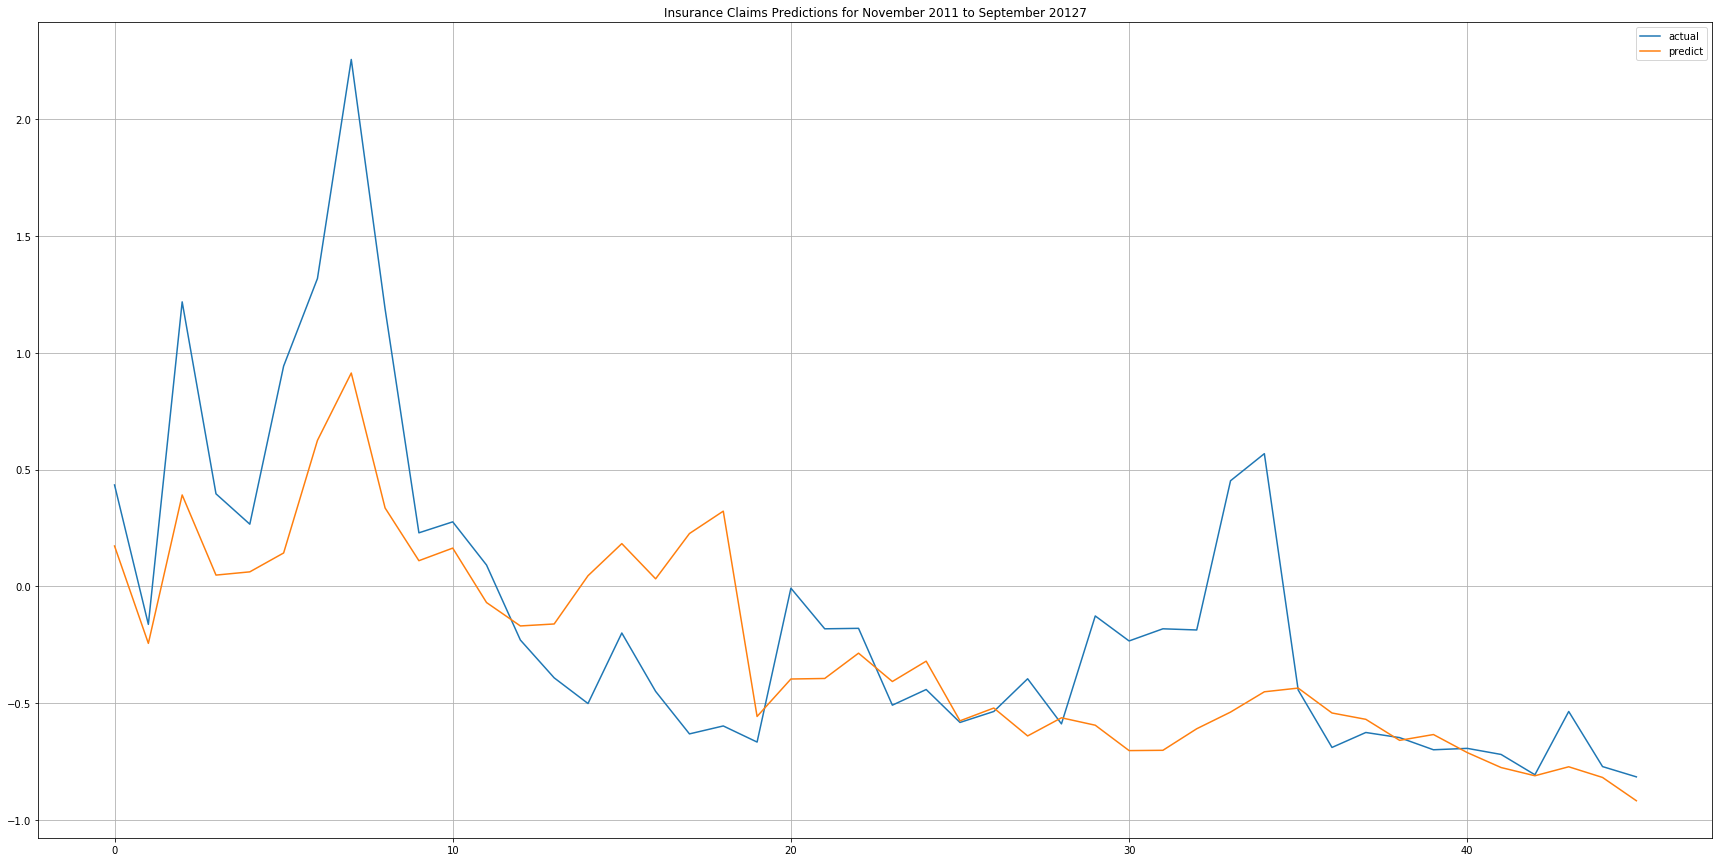

In [9]:
# PREDICTION
lstm_testing = lstm_training.predicting()